#Détection d'anomalie dans le journal de requête (all_logs)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#**Étape 1 : Préparation des Données**
1. Charger les Données
Charger les données depuis le fichier CSV

In [ ]:
import pandas as pd

# Charger les données depuis un fichier CSV
df = pd.read_csv("all_logs.csv")

# Afficher les 5 premières lignes pour vérifier le chargement
print(df.head())


                               Date   Hostname          Process  IdProcess  \
0  2024-12-11T17:14:51.738480+01:00  hilbert02      gnome-shell     2026.0   
1  2024-12-11T17:20:14.050043+01:00  hilbert02  gnome-text-edit     6677.0   
2  2024-12-11T17:30:47.240173+01:00  hilbert02  gnome-text-edit     6677.0   
3  2024-12-11T17:33:26.216539+01:00  hilbert02      gnome-shell     2026.0   
4  2024-12-11T17:37:43.354684+01:00  hilbert02      gnome-shell     2026.0   

                                             Message  
0  meta_window_set_stack_position_no_sync: assert...  
1  Trying to snapshot GtkGizmo 0x559f9a9e7800 wit...  
2  Trying to snapshot GtkGizmo 0x559f9a9e7800 wit...  
3  JS ERROR: TypeError: this.actor is null#012_sy...  
4  endSessionDialog: No XDG_SESSION_ID, fetched f...  


2. Nettoyage des Données
Gérer les valeurs manquantes (e.g., NaN dans IdProcess).

Supprimer ou remplacer les valeurs non pertinentes.

In [ ]:
# Remplacer les NaN dans 'IdProcess' par une valeur indicative, par exemple 'Unknown'
df['IdProcess'] = df['IdProcess'].fillna('Unknown')

# Vérifier les valeurs manquantes restantes
print(df.isnull().sum())


Date         43615
Hostname     43615
Process      43615
IdProcess        0
Message      43615
dtype: int64


3. Normalisation des Timestamps

Convertir les dates pour une manipulation uniforme.

In [ ]:
# Conversion des dates en format datetime
df['Date'] = pd.to_datetime(df['Date'])

# Afficher le format des dates
print(df['Date'].dtypes)


datetime64[ns, UTC+01:00]


4. Extraire les Catégories
Ajouter des colonnes dérivées, comme le type d’erreur basé sur Message.

In [ ]:
# Ajouter une colonne 'ErrorType' basée sur les mots-clés dans 'Message'
def categorize_message(message):
  message= str(message)
  if "Error" in message:
        return "Error"
  elif "Warning" in message:
        return "Warning"
  else:
        return "Info"

df['ErrorType'] = df['Message'].apply(categorize_message)

# Vérifier la distribution des catégories
print(df['ErrorType'].value_counts())


ErrorType
Info       185528
Error        1109
Warning       115
Name: count, dtype: int64


#Étape 2 : Analyse Exploratoire

1. Statistiques de Base
Obtenir des statistiques sur les processus, les hôtes et les erreurs.

In [ ]:
# Comptage des occurrences par Processus
process_count = df['Process'].value_counts()

# Comptage des erreurs par Type
error_count = df['ErrorType'].value_counts()

print("Comptage des Processus :\n", process_count)
print("Comptage des Erreurs :\n", error_count)


Comptage des Processus :
 Process
kernel             60956
systemd            18133
gnome-software     17666
nautilus            8268
rtkit-daemon        7025
                   ...  
gsd-keyboard           2
gsd-wacom              2
mutter-x11-fram        2
gsd-xsettings          2
seahorse               2
Name: count, Length: 376, dtype: int64
Comptage des Erreurs :
 ErrorType
Info       185528
Error        1109
Warning       115
Name: count, dtype: int64


2. Analyse Temporelle
Étudier la répartition des logs au fil du temps.

<ipython-input-27-2a63e1978ece>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  logs_per_hour = df.resample('H').size()


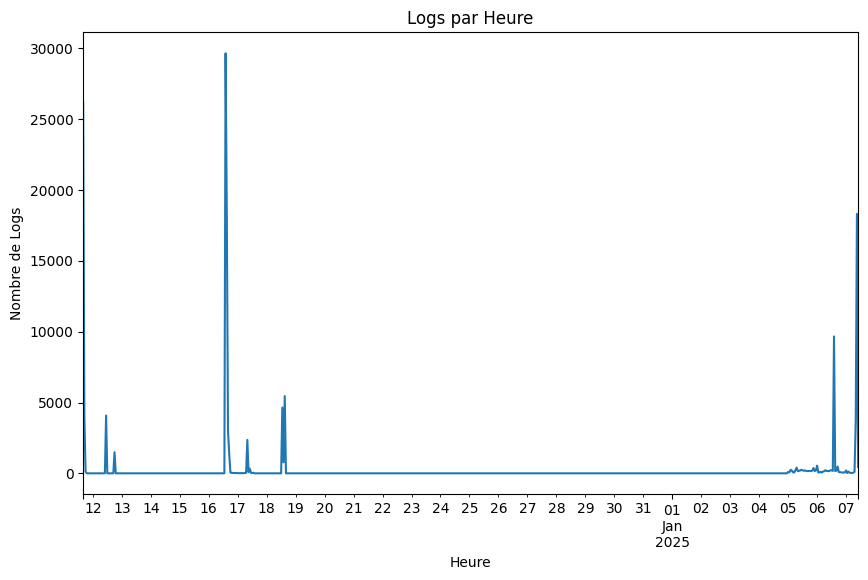

In [ ]:
import matplotlib.pyplot as plt

# Grouper par date pour analyser les fréquences
df.set_index('Date', inplace=True)
logs_per_hour = df.resample('H').size()

# Visualiser les logs par heure
logs_per_hour.plot(kind='line', title="Logs par Heure", figsize=(10, 6))
plt.xlabel("Heure")
plt.ylabel("Nombre de Logs")
plt.show()


3. Processus avec Anomalies
Identifier les processus générant des erreurs fréquentes.

In [ ]:
# Filtrer les erreurs
error_logs = df[df['ErrorType'] == 'Error']

# Comptage des erreurs par Processus
error_by_process = error_logs['Process'].value_counts()

print("Erreurs par Processus :\n", error_by_process)


Erreurs par Processus :
 Process
gnome-shell                       277
gnome-session                     114
gsd-power                          76
xdg-desktop-por                    60
wireplumber                        60
gsd-sharing                        60
gnome-session-binary               57
gsd-usb-protect                    30
at-spi2-registr                    30
evolution-alarm                    30
org.gnome.Shell.desktop            30
evolution-addre                    20
evolution-calen                    20
kdeconnectd                        20
firefox-esr.desktop[6754]          20
gsd-power[12933]                   18
nautilus                           12
gsd-sharing[1492]                  12
kernel                             11
gvfsd                              11
gnome-session[2123]                 8
gnome-shell[2156]                   7
gsd-sharing[1534]                   6
gsd-sharing[12853]                  6
gnome-session[2097]                 6
gsd-power[2354]  

#Étape 3 : Détection des Anomalies

1. Anomalies Basées sur les Fréquences
Identifier des pics inhabituels.

In [ ]:
# Identifier les moments avec un nombre de logs supérieur à une certaine valeur
anomalies = logs_per_hour[logs_per_hour > logs_per_hour.mean() + 2 * logs_per_hour.std()]

print("Anomalies détectées :\n", anomalies)


Anomalies détectées :
 Date
2024-12-11 16:00:00+01:00    26178
2024-12-16 14:00:00+01:00    29652
2024-12-16 15:00:00+01:00    18286
2024-12-18 13:00:00+01:00     4642
2024-12-18 15:00:00+01:00     5451
2025-01-06 14:00:00+01:00     9665
2025-01-07 09:00:00+01:00    18318
dtype: int64


In [34]:
# affiche le nombre d'anomalie

print("Nombre d'anomalies détectées :", len(anomalies))

Nombre d'anomalies détectées : 1844


2. Machine Learning pour Anomalies

In [38]:
from sklearn.ensemble import IsolationForest
import pandas as pd

# Assuming df is your DataFrame

# Replace 'Unknown' with a numerical value, e.g., -1
df['IdProcess'] = pd.to_numeric(df['IdProcess'], errors='coerce').fillna(-1).astype(int)

# Select numerical features (including the modified 'IdProcess')
numerical_data = df[['IdProcess']].dropna()

# Isolation Forest model
model = IsolationForest(contamination=0.01)
numerical_data['Anomaly'] = model.fit_predict(numerical_data[['IdProcess']])

# Anomalies
anomalies = numerical_data[numerical_data['Anomaly'] == -1]
print(anomalies)

                                  IdProcess  Anomaly
Date                                                
2024-12-11 17:20:14.050043+01:00       6677       -1
2024-12-11 17:30:47.240173+01:00       6677       -1
2024-12-16 15:12:39.134396+01:00       6201       -1
2024-12-16 15:14:13.749290+01:00       6262       -1
2024-12-16 15:43:55.107307+01:00       8194       -1
...                                     ...      ...
2024-12-11 16:39:03.836630+01:00       7234       -1
2024-12-11 16:39:03.836719+01:00       7234       -1
2024-12-11 16:39:03.836920+01:00       7234       -1
2024-12-11 16:39:03.837011+01:00       7234       -1
2024-12-16 15:44:01.608941+01:00      48562       -1

[1790 rows x 2 columns]


<ipython-input-39-d5bc503849ce>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_indices = anomalies_if.index.floor('H') # Floor timestamps to the nearest hour


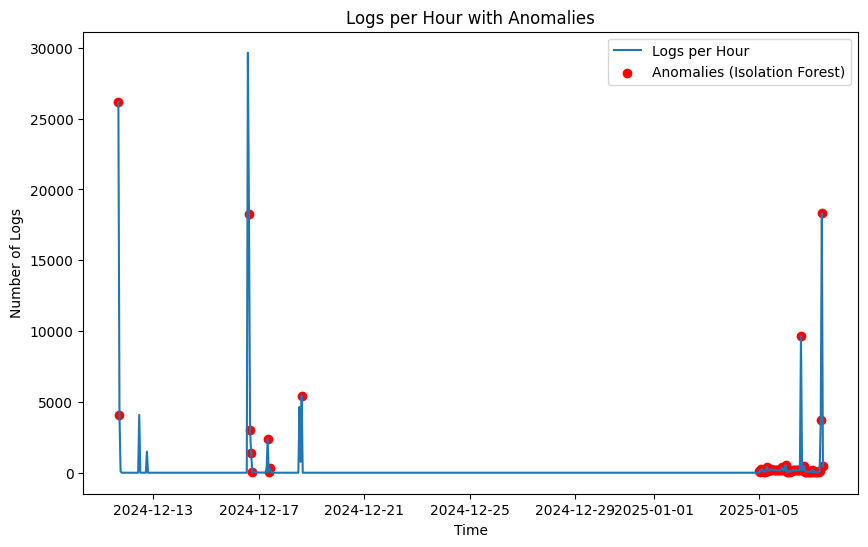

In [39]:
plt.figure(figsize=(10,6))
plt.plot(logs_per_hour.index, logs_per_hour.values, label='Logs per Hour')

# Get the hourly timestamps from anomalies_if
anomaly_indices = anomalies_if.index.floor('H') # Floor timestamps to the nearest hour

# Only select anomalies that exist in logs_per_hour
# This step is crucial for aligning the indices
common_indices = anomaly_indices.intersection(logs_per_hour.index)
anomaly_values = logs_per_hour.loc[common_indices]

plt.scatter(common_indices, anomaly_values, color='red', label='Anomalies (Isolation Forest)')

plt.title('Logs per Hour with Anomalies')
plt.xlabel('Time')
plt.ylabel('Number of Logs')
plt.legend()
plt.show()

#Étape 4 : Génération de Rapports
1. Tableaux Résumés
Générer des statistiques utiles.

In [ ]:
# Rapports sur les processus les plus actifs
top_processes = df['Process'].value_counts().head(10)

# Rapports sur les erreurs
top_errors = error_logs['Message'].value_counts().head(10)

print("Top 10 Processus :\n", top_processes)
print("Top 10 Messages d'erreurs :\n", top_errors)


Top 10 Processus :
 Process
kernel            60956
systemd           18133
gnome-software    17666
nautilus           8268
rtkit-daemon       7025
nslcd              5676
packagekitd        3568
dbus-daemon        3286
gnome-shell        2965
anacron            1296
Name: count, dtype: int64
Top 10 Messages d'erreurs :
 Message
Error reading events from display: Relais brisé (pipe)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             130
Received error from D-Bus search provi

2. Graphiques
Créer des visualisations comme les diagrammes circulaires ou les barres.

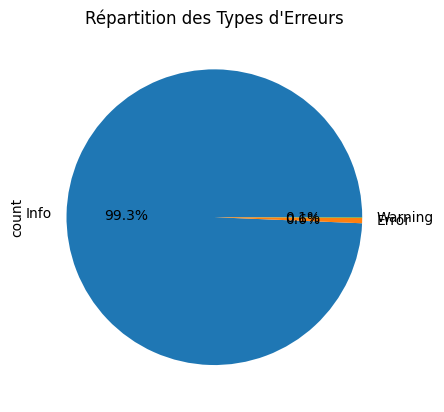

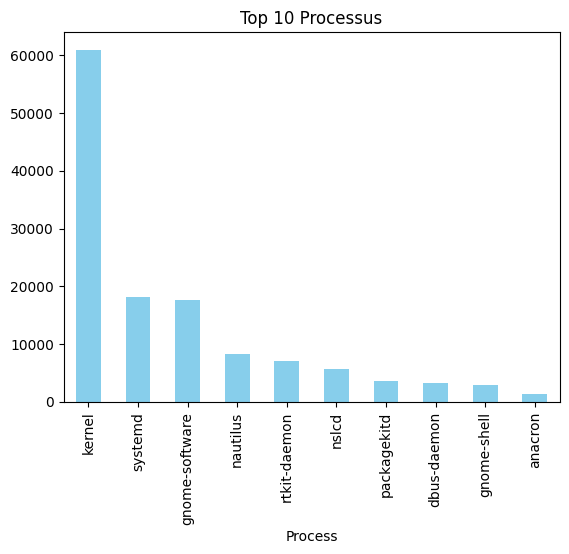

In [ ]:
# Diagramme circulaire des types d'erreurs
df['ErrorType'].value_counts().plot(kind='pie', autopct='%1.1f%%', title="Répartition des Types d'Erreurs")
plt.show()

# Histogramme des processus les plus fréquents
df['Process'].value_counts().head(10).plot(kind='bar', title="Top 10 Processus", color='skyblue')
plt.show()


In [40]:
# Exporter les résultats
df.to_csv("preprocess_logs.csv", index=False)
